In [1]:
import os
import sys
import ast
import pickle

glp = os.path.abspath("../code")
if not glp in sys.path: sys.path.append( glp )

from global_paths import global_paths

if not global_paths["COBS"] in sys.path: sys.path.append( global_paths["COBS"] )

In [2]:
import cobs
import torch
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from BuildingOccupancy import Person, Meeting, WeeklyMeeting, OneTimeMeeting, BuildingOccupancy
from DefaultBuildings import Building_5ZoneAirCooled
from Agents import agent_constructor
from CentralController import ddpg_episode_mc
import RLCritics
import StateUtilities as SU

In [4]:
import visualization_helper_v2 as vh

In [5]:
fig_width = 15

In [6]:
dirnames = ['../checkpoints/b001/', # baseline fairfax
            '../checkpoints/b002/', # baseline fairfax, modified setpoints
            '../checkpoints/b003/'] # baseline fairfax, further modified setpoints

In [7]:
alldfs = [ vh.convert_sqlite_to_df(dirname) for dirname in dirnames ]

Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.
Table eels convertet to a pandas dataframe.
Table sees convertet to a pandas dataframe.
Table seesea convertet to a pandas dataframe.
Table sees_er convertet to a pandas dataframe.


In [8]:
last_available_eval_episodes = []
for idx, dfs in enumerate(alldfs):
    last_eval_episode = dfs['sees'].loc[:, "episode"].unique()[-1]
    last_available_eval_episodes.append(last_eval_episode)
    print(f"Last available evaluation episode for dfs{idx}: {last_eval_episode:6}")

Last available evaluation episode for dfs0:      0
Last available evaluation episode for dfs1:      0
Last available evaluation episode for dfs2:      0


<h3>Details: Temperatur Setpoints</h3>

In [9]:
if not "selected_episodes" in locals().keys():
    selected_episodes = last_available_eval_episodes.copy()
if not "selected_weeks" in locals().keys():
    # the start of the evaluation episode
    selected_weeks = [datetime.datetime.strptime(dfs['sees'].iloc[0]["datetime"], "%Y-%m-%d %H:%M:%S")
                      for dfs in alldfs]

subdfs = []
for idx, dfs in enumerate(alldfs):
    subdfs1 = vh.select_week_and_episode(dfs, selected_episodes[idx], selected_weeks[idx])
    subdfs.append( subdfs1 )

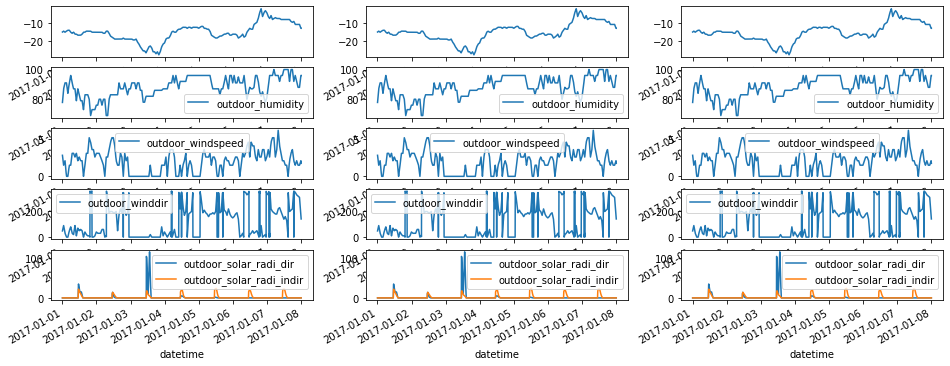

In [10]:
_, axes = plt.subplots(nrows=5, ncols=3, figsize=(16,6))
for idx, dfs in enumerate(subdfs):
    vh.plot_sees(dfs, axes[:, idx])

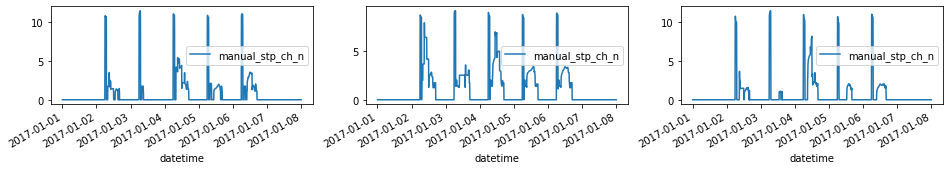

In [11]:
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(16,2))
for idx, dfs in enumerate(subdfs):
    vh.plot_sees_only_mstpc(dfs, axes[idx])

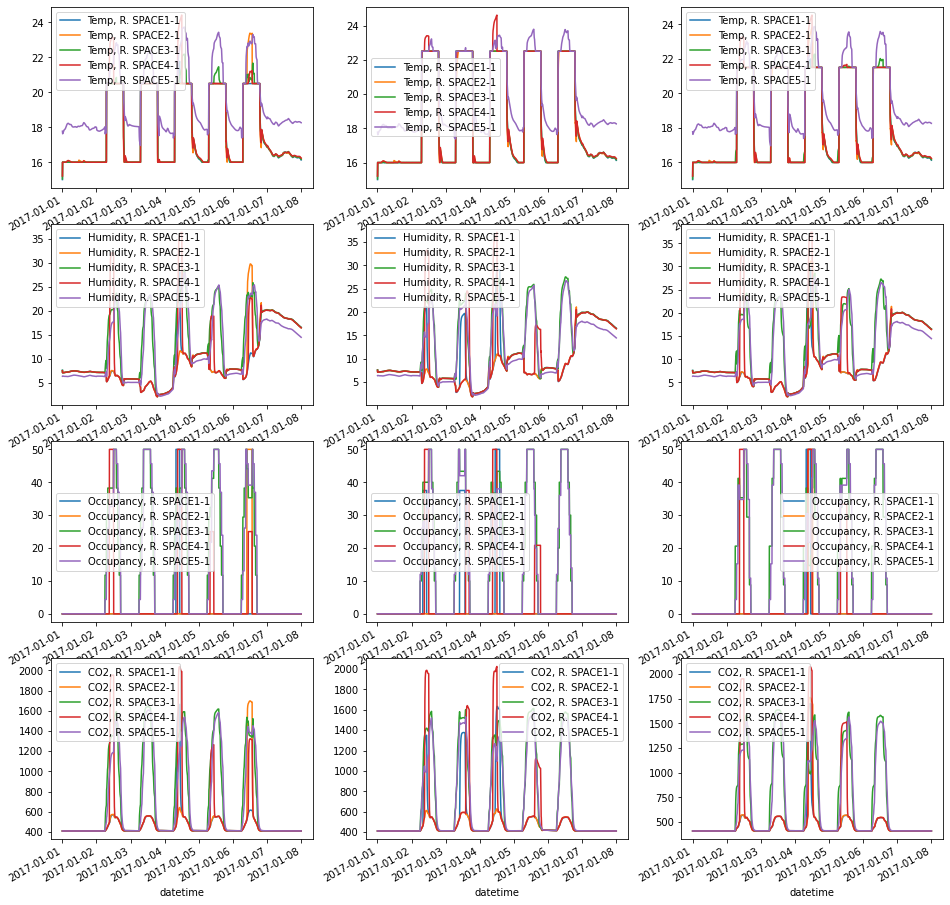

In [12]:
_, axes = plt.subplots(nrows=4, ncols=3, figsize=(16,17))
for idx, dfs in enumerate(subdfs):
    vh.plot_seeser_all_rooms(dfs, axes[:, idx])
# for individual rooms use plot_seeser(subdfs, room_id, ax)

In [13]:
subdfs_rooms  = []
subdfs_agents = []

for idx, sdfs in enumerate(subdfs):
    sdfs_rooms  = sdfs["seeser"].loc[:, "room"].unique()
    sdfs_agents = sdfs["seesea"].loc[:, "agent_nr"].unique()
    subdfs_rooms.append(sdfs_rooms)
    subdfs_agents.append(sdfs_agents)
    print(f"Available Rooms     in subdfs{idx}: {sdfs_rooms}")
    print(f"Available Agent IDs in subdfs{idx}: {sdfs_agents}", "\n")

Available Rooms     in subdfs0: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in subdfs0: [0 1 2 3 4] 

Available Rooms     in subdfs1: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in subdfs1: [0 1 2 3 4] 

Available Rooms     in subdfs2: ['SPACE1-1' 'SPACE2-1' 'SPACE3-1' 'SPACE4-1' 'SPACE5-1']
Available Agent IDs in subdfs2: [0 1 2 3 4] 



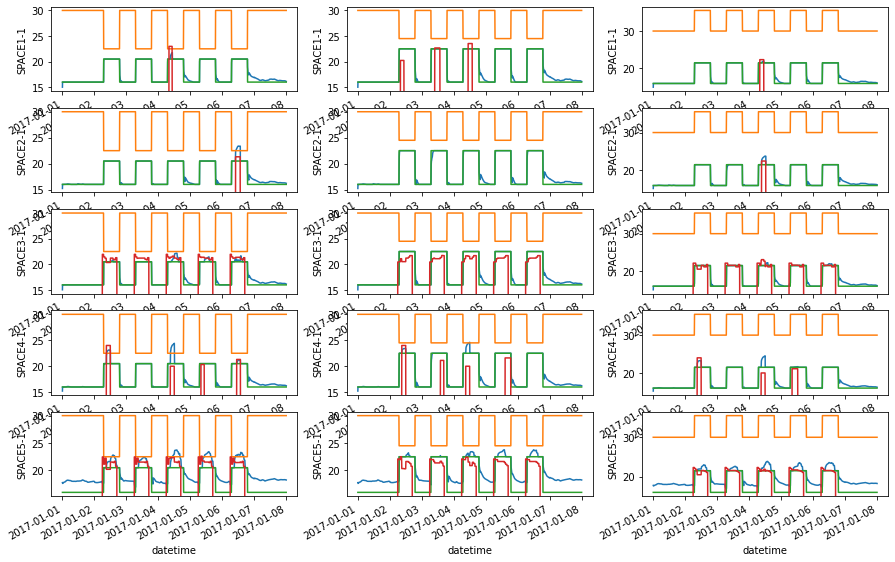

In [14]:
max_n_agents = max(2, max([len(sdfs_agents) for sdfs_agents in subdfs_agents]))
_, axes = plt.subplots(nrows=max_n_agents, ncols=len(alldfs), figsize=(fig_width,2*max_n_agents))
for idx, sdfs in enumerate(subdfs):
    for idx2, room, agentid in zip(range(len(subdfs_rooms[idx])), subdfs_rooms[idx], subdfs_agents[idx]):
        vh.plot_room_temp_agent_setpoint(sdfs, room, agentid, axes[idx2, idx])

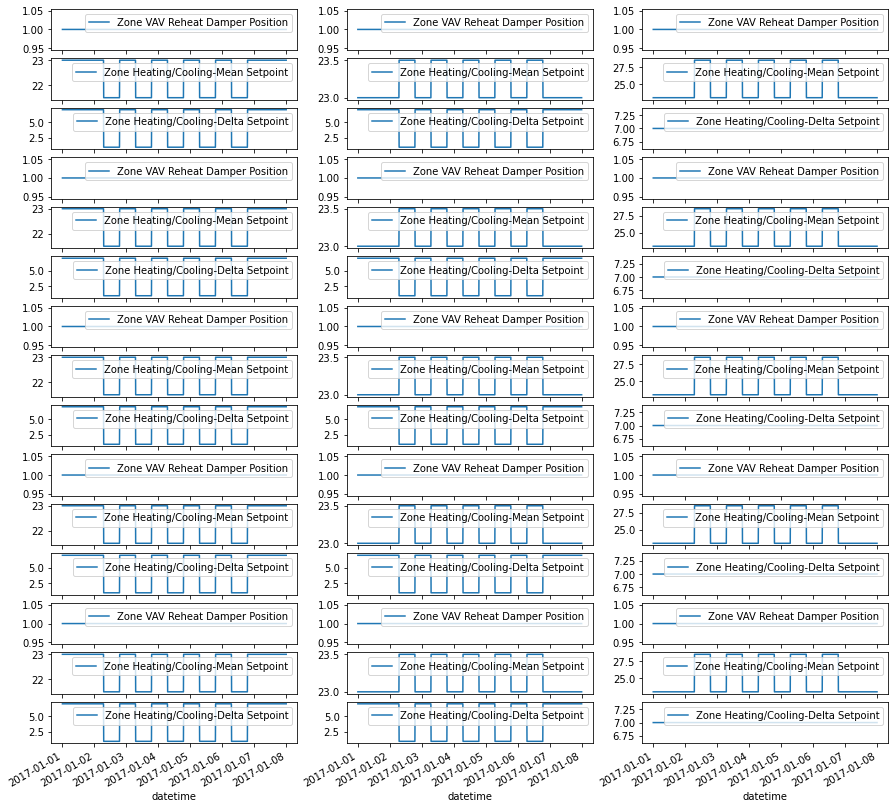

In [15]:
nrows = max_n_agents * max([sdfs['seesea'].iloc[0]["agent_actions"].count(":") for sdfs in subdfs])
_, axes = plt.subplots(nrows=nrows, ncols=len(alldfs), figsize=(fig_width,nrows), sharex=True)
for a in axes.flatten():
    a.ticklabel_format(useOffset=False, style='plain')
for idx, sdfs in enumerate(subdfs):
    vh.plot_seesea(sdfs, axes[:, idx])

<h3>Details for a day</h3>

In [16]:
selected_periods     = [datetime.datetime(2017, 1, 3), datetime.datetime(2017, 1, 3), datetime.datetime(2017, 1, 3)]
selected_periods_end = [datetime.datetime(2017, 1, 4), datetime.datetime(2017, 1, 4), datetime.datetime(2017, 1, 4)]

subdfs = []
for idx, dfs in enumerate(alldfs):
    subdfs1 = vh.select_week_and_episode(dfs, selected_episodes[idx],
                                         selected_periods[idx], selected_periods_end[idx])
    subdfs.append(subdfs1)

/proj/ciptmp/me14miju/pyenvs/masterarbeit37/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  app.launch_new_instance()


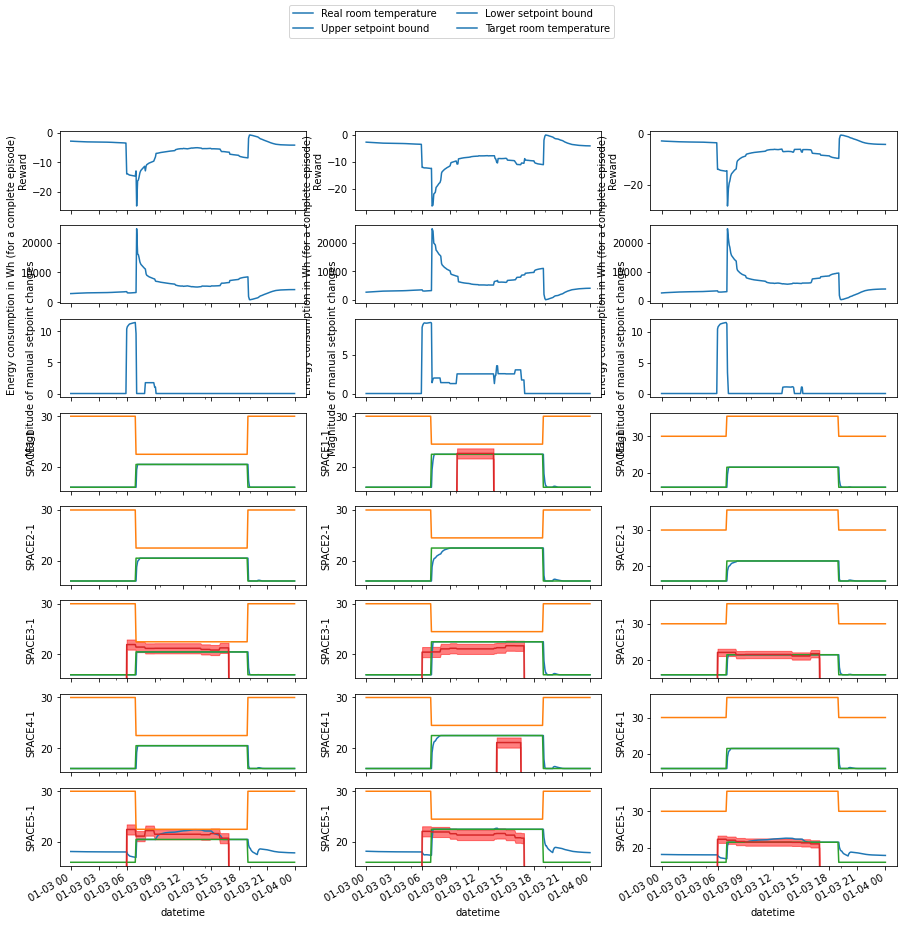

In [25]:
max_n_agents = max(2, max([len(sdfs_agents) for sdfs_agents in subdfs_agents]))
p, axes = plt.subplots(nrows=max_n_agents+3, ncols=len(alldfs), figsize=(fig_width,3*max_n_agents), sharex=True)

# plot rewards
for idx, dfs in enumerate(alldfs):
    vh.plot_sees_reward(subdfs[idx], axes[:, idx])

# plot for every room
for idx, sdfs in enumerate(subdfs):
    for idx2, room, agentid in zip(range(len(subdfs_rooms[idx])), subdfs_rooms[idx], subdfs_agents[idx]):
        idx2offset = idx2+3
        l1, l2, l3, l4 = vh.plot_room_temp_agent_setpoint(sdfs, room, agentid, axes[idx2offset, idx], True)

p.legend([l1, l2, l3, l4],
         labels=["Real room temperature", "Upper setpoint bound", "Lower setpoint bound", "Target room temperature"],
         loc="upper center",
         ncol=2)
#p.subplots_adjust(right=0.7)
p.show()

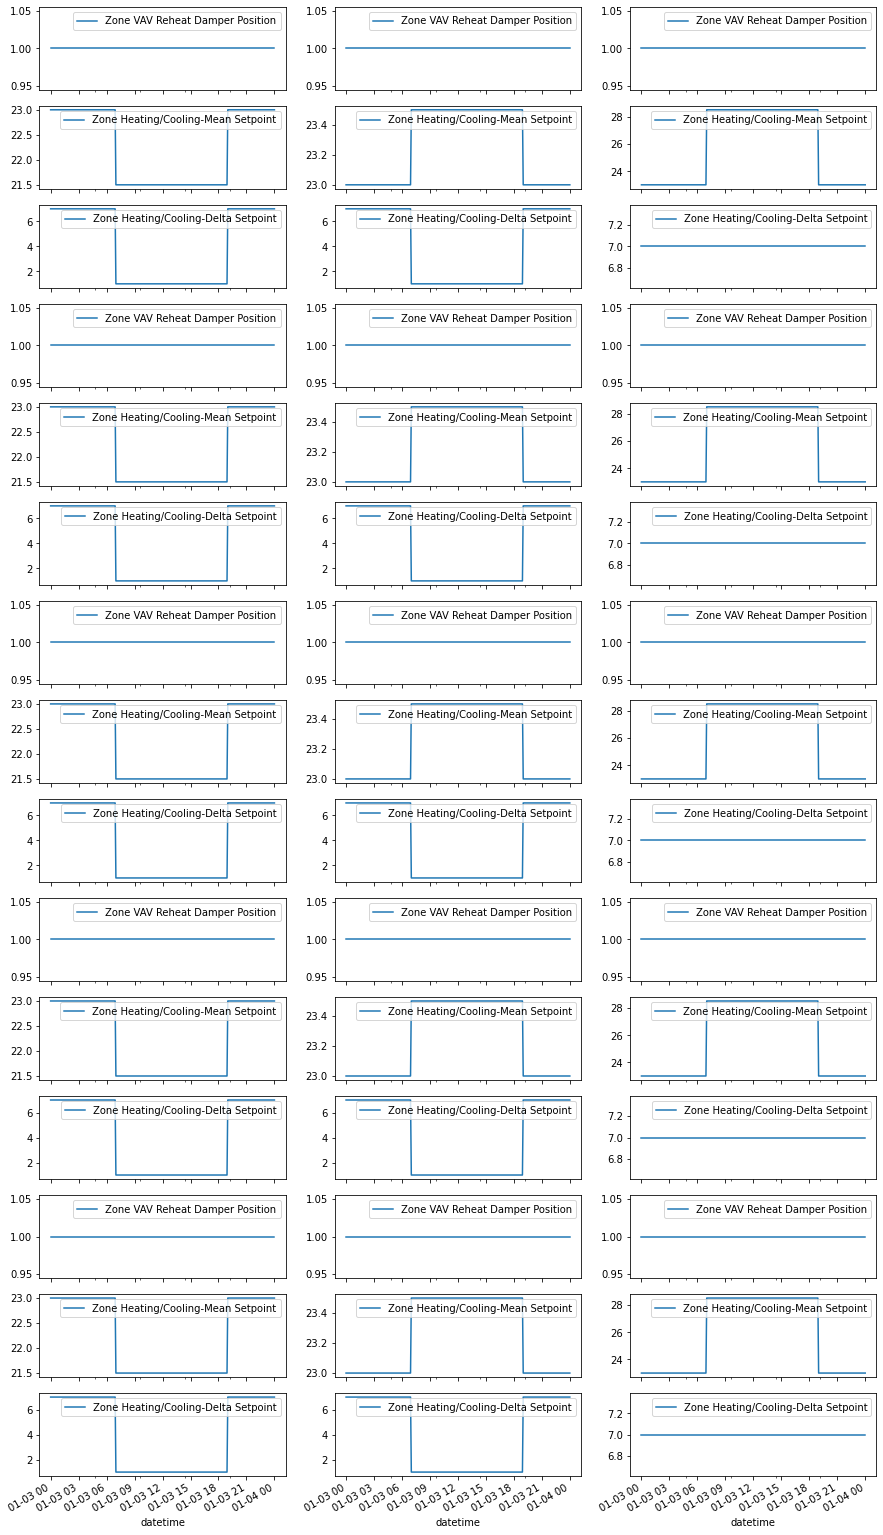

In [19]:
nrows = max_n_agents * max([sdfs['seesea'].iloc[0]["agent_actions"].count(":") for sdfs in subdfs])
_, axes = plt.subplots(nrows=nrows, ncols=len(alldfs), figsize=(fig_width,2*nrows), sharex=True)
for a in axes.flatten():
    a.ticklabel_format(useOffset=False, style='plain')
for idx, sdfs in enumerate(subdfs):
    vh.plot_seesea(sdfs, axes[:, idx])